In [1]:

import matplotlib.pyplot as plt
import numpy as np

from src.quantum_knapsack import *

In [ ]:
@timer_decorator
def create_knapsack(values, weights, capacity):
    return Knapsack(values, weights, capacity)

@timer_decorator
def create_coffey(knapsack):
    return Coffey(knapsack)

@timer_decorator
def create_basis(dimension):
    return StandardBasis(dimension)

@timer_decorator
def coffey_init(coffey, basis, penalty_scale):
    coffey.init(basis, penalty_scale)

@timer_decorator
def create_solver(basis, coffey):
    return QuantumAnnealer(basis, coffey)

@timer_decorator
def solver_init(solver, h_strength, max_iterations):
    solver.init(h_strength, max_iterations)

@timer_decorator
def solve(solver, tolerance):
    solver.solve(tolerance)

@timer_decorator
def format_result(solver, max_time):
    return solver.format_result(max_time)

@timer_decorator
def compute_probabilities(result):
    result.compute_probabilities()

@timer_decorator
def compute_expectation_values(result):
    result.compute_expectation_values()


In [2]:
# values = np.array([10, 2])
# weights = np.array([1, 2])
# capacity = 2

values = np.array([8, 3, 5, 6, 9])
weights = np.array([1, 2, 1, 3, 2])
capacity = 7

# values = np.array([6, 5, 8, 9, 6, 7, 3])
# weights = np.array([2, 3, 6, 7, 5, 8, 4])
# capacity = 9

knapsack = Knapsack(values, weights, capacity)
print(knapsack)

coffey = Coffey(knapsack)

basis = StandardBasis(coffey.get_dimension())
penalty_scale = 10.0
coffey.init(basis, penalty_scale)

solver = QuantumAnnealer(basis, coffey)
solver.init(2.5, 201)

@timer_decorator
def fn1():
    solver.solve(0.0001)

fn1()

result: Result = solver.format_result(100)

@timer_decorator
def fn2():
    result.compute_probabilities()

fn2()

@timer_decorator
def fn3():
    result.compute_expectation_values()

fn3()

expectation_values = result.get_expectation_values()
print(
    f"Expectation values: {", ".join([f"{s:.3f}" for s in expectation_values])}"
)
print(f"Final expectation value: {expectation_values[-1]}")


Knapsack Problem:
Capacity: 7
| Profit | Weight |
|--------|--------|
|   8    |   1    |
|   3    |   2    |
|   5    |   1    |
|   6    |   3    |
|   9    |   2    |

Function 'fn1' took 1.2349 seconds to execute
Function 'fn2' took 0.0928 seconds to execute
Function 'fn3' took 0.4784 seconds to execute
Expectation values: -77.752, -74.923, -72.681, -71.067, -69.592, -68.122, -66.802, -65.630, -64.412, -63.290, -62.119, -61.024, -59.923, -58.864, -57.808, -56.795, -55.792, -54.786, -53.800, -52.805, -51.838, -50.885, -49.934, -48.985, -48.044, -47.118, -46.210, -45.305, -44.413, -43.534, -42.665, -41.825, -40.985, -40.158, -39.340, -38.535, -37.763, -36.970, -36.164, -35.435, -34.687, -33.902, -33.161, -32.485, -31.741, -31.071, -30.368, -29.683, -29.021, -28.335, -27.702, -27.069, -26.446, -25.813, -25.231, -24.638, -24.072, -23.532, -22.996, -22.459, -21.939, -21.444, -20.919, -20.428, -19.954, -19.466, -18.985, -18.536, -18.081, -17.638, -17.215, -16.823, -16.404, -16.053, -15.7

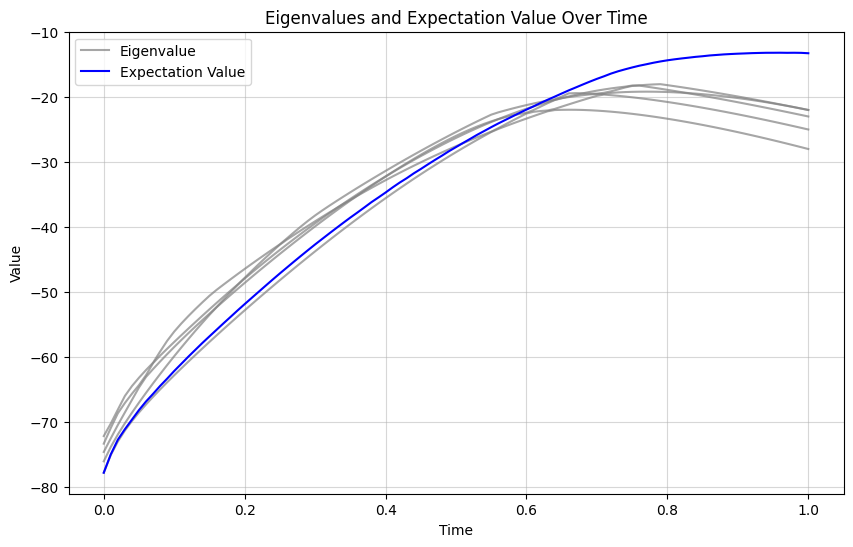

In [3]:
time = result.get_times()
expectation_values = result.get_expectation_values()
eigenvalues = np.array([ev[:5] for ev in result.get_eigenspectrum()])

plt.figure(figsize=(10, 6))

# Plot the 5 smallest eigenvalues over time
for i in range(5):
    plt.plot(time, eigenvalues[:, i], color="grey", linestyle="-", alpha=0.7, label="Eigenvalue" if i == 0 else "")

# Plot the expectation value over time
plt.plot(time, expectation_values, color="blue", linestyle="-", label="Expectation Value")

# Customizing the plot
plt.title("Eigenvalues and Expectation Value Over Time")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(visible=True, linestyle="-", alpha=0.5)

plt.show()

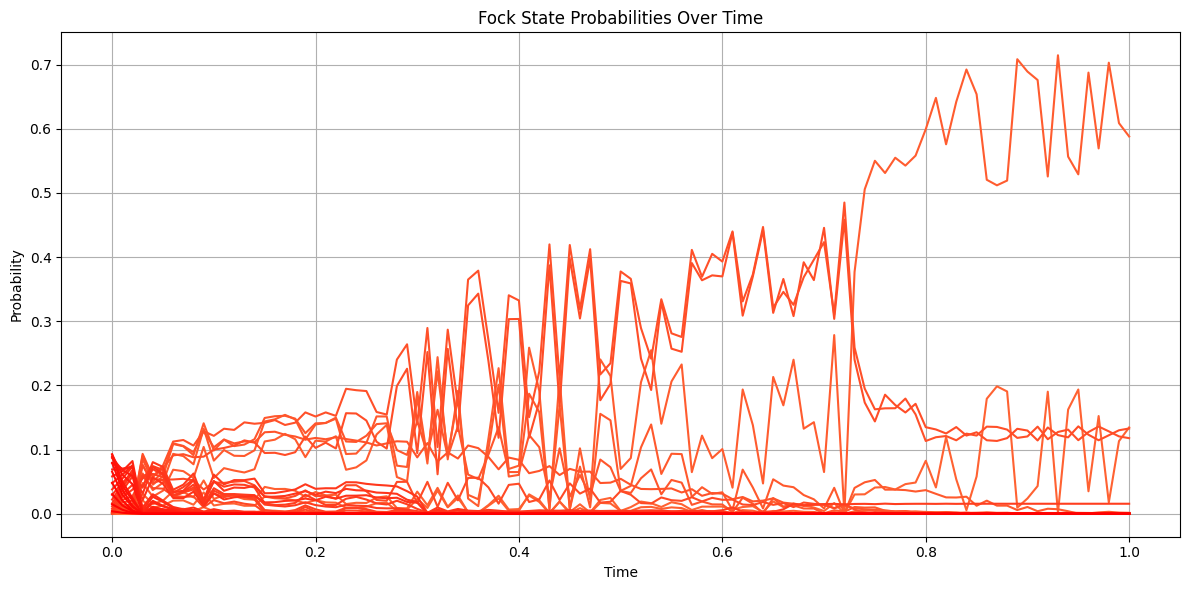

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get probabilities and times from result
probabilities = result.get_probabilities()
times = result.get_times()

# Create the plot
plt.figure(figsize=(12, 6))

# Get number of states
n_states = len(probabilities[0])

# Create a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, n_states))

# Plot each state's probability
for i in range(n_states):
    state_probs = [prob[i] for prob in probabilities]
    plt.plot(times, state_probs, label=f'$|{i}\\rangle$', color=colors[i])

plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Fock State Probabilities Over Time')
plt.grid(True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from IPython.display import display

# Get the final probabilities (last time step)
final_probs = result.get_probabilities()[-1]

# Calculate number of ancillary qubits needed
n_items = len(weights)
n_ancilla = int(np.ceil(np.log2(capacity + 1)))  # number of ancillary qubits

# Calculate ancillary weights (powers of 2)
ancilla_weights = [2 ** i for i in range(n_ancilla - 1)] + [knapsack.get_capacity() + 1 - 2 ** (n_ancilla - 1)]

# Create data for the table
n_states = len(final_probs)
data = []
for state_idx in range(n_states):
    # Convert state index to binary representation for all qubits (items + ancilla)
    total_bits = n_items + n_ancilla
    binary = format(state_idx, f'0{total_bits}b')

    # Split binary string into items and ancilla bits
    items_binary = binary[:n_items]
    ancilla_binary = binary[n_items:]

    items = [int(b) for b in items_binary]
    ancilla = [int(b) for b in ancilla_binary]

    # Calculate values
    total_value = sum(v * i for v, i in zip(values, items))
    total_weight = sum(w * i for w, i in zip(weights, items))
    ancilla_sum = sum(w * a for w, a in zip(ancilla_weights, ancilla))

    # Check if solution is valid (weight equals ancilla sum)
    is_valid = total_weight == ancilla_sum

    # Add row to data
    data.append({
        'State': f'|{state_idx}⟩',
        'Items Binary': items_binary,
        'Items': items,
        'Ancilla Binary': ancilla_binary,
        'Ancilla Sum': ancilla_sum,
        'Total Value': total_value,
        'Total Weight': total_weight,
        'Valid': is_valid,
        'Probability': f'{final_probs[state_idx]:.4f}'
    })

# Create DataFrame and sort by probability
df = pd.DataFrame(data)
df = df.sort_values('Probability', ascending=False)


# Create a style function to highlight valid solutions
def highlight_valid(row):
    return ['background-color: palegreen' if row['Valid'] else '' for _ in row]


# Display the table with highlighting
# display(df.style.apply(highlight_valid, axis=1).set_properties(**{'text-align': 'center'}))

# Print the most probable solution
most_probable = df.iloc[0]
print("\nMost probable solution:")
print(f"State: {most_probable['State']}")
print(f"Items configuration: {most_probable['Items']}")
print(f"Ancilla bits: {most_probable['Ancilla Binary']}")
print(f"Ancilla sum: {most_probable['Ancilla Sum']}")
print(f"Total value: {most_probable['Total Value']}")
print(f"Total weight: {most_probable['Total Weight']}")
print(f"Valid solution: {most_probable['Valid']}")
print(f"Probability: {most_probable['Probability']}")

# Print system information
print("\nSystem information:")
print(f"Number of items: {n_items}")
print(f"Number of ancilla qubits: {n_ancilla}")
print(f"Total number of qubits: {n_items + n_ancilla}")
print(f"Ancilla weights: {ancilla_weights}")
print(f"Capacity: {capacity}")


Most probable solution:
State: |225⟩
Items configuration: [1, 1, 1, 0, 0]
Ancilla bits: 001
Ancilla sum: 4
Total value: 16
Total weight: 4
Valid solution: True
Probability: 0.5880

System information:
Number of items: 5
Number of ancilla qubits: 3
Total number of qubits: 8
Ancilla weights: [1, 2, 4]
Capacity: 7


In [6]:
# Filter and display only valid solutions
valid_df = df[df['Valid']].copy()

# Display the filtered table
display(valid_df.style.set_properties(**{'text-align': 'center'}))

# Print summary
print("\nValid solutions summary:")
print(f"Number of valid solutions: {len(valid_df)}")
print(f"Total probability of valid solutions: {sum(float(p) for p in valid_df['Probability']):.4f}")

if len(valid_df) > 0:
    best_valid = valid_df.iloc[0]
    print("\nMost probable valid solution:")
    print(f"State: {best_valid['State']}")
    print(f"Items configuration: {best_valid['Items']}")
    print(f"Ancilla bits: {best_valid['Ancilla Binary']}")
    print(f"Total value: {best_valid['Total Value']}")
    print(f"Total weight: {best_valid['Total Weight']}")
    print(f"Probability: {best_valid['Probability']}")

,State,Items Binary,Items,Ancilla Binary,Ancilla Sum,Total Value,Total Weight,Valid,Probability
225,|225⟩,11100,"[1, 1, 1, 0, 0]",001,4,16,4,True,0.5880
235,|235⟩,11101,"[1, 1, 1, 0, 1]",011,6,25,6,True,0.0157
191,|191⟩,10111,"[1, 0, 1, 1, 1]",111,7,28,7,True,0.0012
198,|198⟩,11000,"[1, 1, 0, 0, 0]",110,3,11,3,True,0.0012
205,|205⟩,11001,"[1, 1, 0, 0, 1]",101,5,20,5,True,0.0012
155,|155⟩,10011,"[1, 0, 0, 1, 1]",011,6,23,6,True,0.0005
145,|145⟩,10010,"[1, 0, 0, 1, 0]",001,4,14,4,True,0.0002
169,|169⟩,10101,"[1, 0, 1, 0, 1]",001,4,22,4,True,0.0002
247,|247⟩,11110,"[1, 1, 1, 1, 0]",111,7,22,7,True,0.0001
211,|211⟩,11010,"[1, 1, 0, 1, 0]",011,6,17,6,True,0.0001



Valid solutions summary:
Number of valid solutions: 29
Total probability of valid solutions: 0.6084

Most probable valid solution:
State: |225⟩
Items configuration: [1, 1, 1, 0, 0]
Ancilla bits: 001
Total value: 16
Total weight: 4
Probability: 0.5880


In [7]:
result.get_correct_solutions()

{'solutions': [{'state': 191,
   'items': [1, 0, 1, 1, 1],
   'value': np.int64(28),
   'weight': np.int64(7),
   'probability': np.float64(0.0011991653789635165)}],
 'total_probability': np.float64(0.0011991653789635165),
 'number_of_solutions': 1}


Optimal solutions:
Items: [1, 0, 1, 1, 1], Value: 28, Weight: 7
Processing iteration 3600/3600
Heatmap calculation complete!


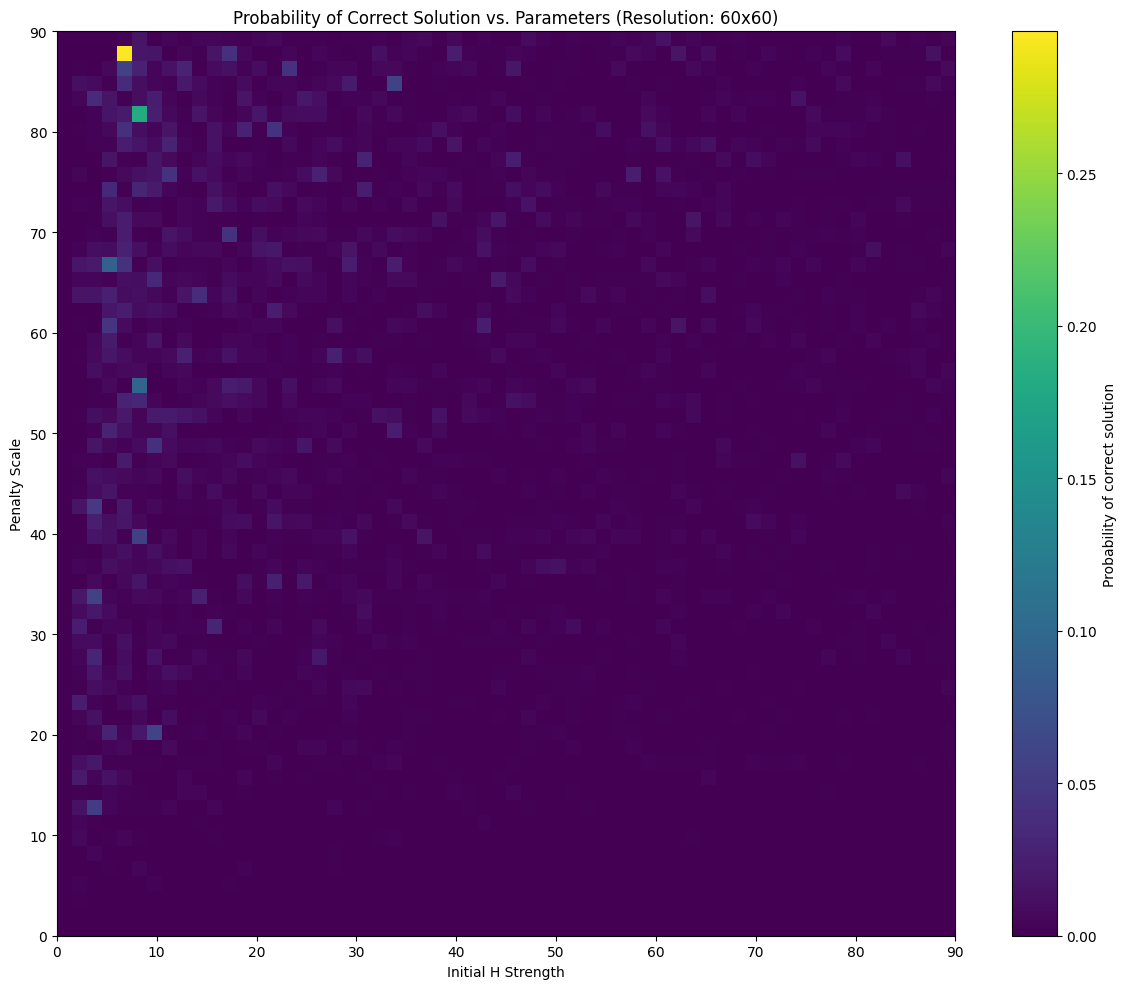


Best parameters found:
Penalty Scale: 88.47
Initial H Strength: 6.10
Probability: 0.297


(array([[1.13681061e-16, 1.53304525e-06, 8.25655563e-07, ...,
         2.84634336e-06, 3.09821695e-06, 1.22342132e-06],
        [1.13681061e-16, 2.26394698e-04, 5.38788707e-05, ...,
         1.75418303e-05, 2.11085536e-05, 1.26444688e-04],
        [1.13681061e-16, 2.03279852e-03, 3.14294233e-04, ...,
         5.42138393e-05, 1.34502257e-04, 1.45256994e-05],
        ...,
        [1.13681061e-16, 1.68319025e-03, 1.15429556e-03, ...,
         4.00852053e-04, 7.38218133e-04, 7.12133484e-03],
        [1.13681061e-16, 2.13304801e-04, 1.15220454e-03, ...,
         1.21000325e-03, 1.29618931e-02, 2.45058981e-04],
        [1.13681061e-16, 6.85946107e-04, 5.93420084e-04, ...,
         2.97572440e-03, 5.91342687e-04, 4.42011564e-03]], shape=(60, 60)),
 array([ 0.        ,  1.52542373,  3.05084746,  4.57627119,  6.10169492,
         7.62711864,  9.15254237, 10.6779661 , 12.20338983, 13.72881356,
        15.25423729, 16.77966102, 18.30508475, 19.83050847, 21.3559322 ,
        22.88135593, 24.406779

In [8]:
def create_knapsack_heatmap(min_val=0, max_val=50, resolution=6):
    """
    Create a heatmap of solution probabilities with variable resolution.
    """
    # Define the problem parameters
    # values = np.array([10, 2])
    # weights = np.array([1, 2])
    # capacity = 2

    values = np.array([8, 3, 5, 6, 9])
    weights = np.array([1, 2, 1, 3, 2])
    capacity = 7

    # values = np.array([6, 5, 8, 9, 6, 7, 3])
    # weights = np.array([2, 3, 6, 7, 5, 8, 4])
    # capacity = 9

    # Create knapsack instance and solution analyzer
    knapsack = Knapsack(values, weights, capacity)
    analyzer = SolutionAnalyzer(knapsack)

    # Parameter ranges
    penalty_scales = np.linspace(min_val, max_val, resolution)
    initial_h_strengths = np.linspace(min_val, max_val, resolution)

    # Initialize results matrix
    probabilities = np.zeros((len(penalty_scales), len(initial_h_strengths)))

    # Progress tracking
    total_iterations = len(penalty_scales) * len(initial_h_strengths)
    current_iteration = 0

    # Print optimal solutions once
    solutions = analyzer.get_solutions()
    print("\nOptimal solutions:")
    for items, value, weight in solutions:
        print(f"Items: {items}, Value: {value}, Weight: {weight}")

    # Iterate through parameter combinations
    for i, penalty_scale in enumerate(penalty_scales):
        for j, h_strength in enumerate(initial_h_strengths):
            # Progress update
            current_iteration += 1
            print(f"Processing iteration {current_iteration}/{total_iterations}", end='\r')

            # Initialize solver components
            coffey = Coffey(knapsack)
            basis = StandardBasis(coffey.get_dimension())
            coffey.init(basis, penalty_scale)

            # Initialize and run solver
            solver = QuantumAnnealer(basis, coffey)
            solver.init(h_strength, 201)
            solver.solve(0.0001)

            # Get results
            result = solver.format_result(100)
            result.compute_probabilities()

            # Get final probabilities and calculate correct solution probability
            final_probs = result.get_probabilities()[-1]
            prob = analyzer.get_solution_probability(final_probs)
            probabilities[i, j] = prob

    print("\nHeatmap calculation complete!")

    # Create heatmap visualization
    plt.figure(figsize=(12, 10))
    heatmap = plt.imshow(probabilities, cmap='viridis',
                         extent=[min_val, max_val, min_val, max_val],
                         aspect='auto', origin='lower')

    plt.colorbar(heatmap, label='Probability of correct solution')
    plt.xlabel('Initial H Strength')
    plt.ylabel('Penalty Scale')
    plt.title(f'Probability of Correct Solution vs. Parameters (Resolution: {resolution}x{resolution})')

    if resolution <= 8:
        for i in range(len(penalty_scales)):
            for j in range(len(initial_h_strengths)):
                plt.text(initial_h_strengths[j], penalty_scales[i],
                         f'{probabilities[i, j]:.3f}',
                         ha='center', va='center', color='white')

    plt.tight_layout()
    plt.show()

    # Print the best parameters
    best_idx = np.unravel_index(np.argmax(probabilities), probabilities.shape)
    print(f"\nBest parameters found:")
    print(f"Penalty Scale: {penalty_scales[best_idx[0]]:.2f}")
    print(f"Initial H Strength: {initial_h_strengths[best_idx[1]]:.2f}")
    print(f"Probability: {probabilities[best_idx]:.3f}")

    return probabilities, penalty_scales, initial_h_strengths

create_knapsack_heatmap(min_val=0, max_val=90, resolution=60)